This was an individual project and I did everything in it. 

For task 1, I used Claude to help explain how SIFT works and what the implementation should look like.

For task 2, I had Claude reuse parts of my code from task 1, but for every tile. This task was significantly harder for me to complete. Originally, the reconstructed image did not match at all. The first thing I tried was changing the Lowe's ratio to be more and less strict. This barely affected performance. Then, I tried only allowing one tile from the scrambled image to match the original image. This helped some, but it did not improve by very much. 

What ended up really working was changing the default SIFT parameters. By dramatically increasing `nOctaveLayers` and `edgeThreshold` while also decreasing `contrastThreshold`, I was able to get much, much better performance. Changing the amount of initial gaussian blur didn't seem to help that much. Then with the better SIFT parameters, I changed the Lowe's ratio to be much more tolerant. 

# Task 1: Localize a Hidden Object in the Scene 

In [126]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

template = cv2.imread('auburn.jpeg')
scene = cv2.imread('Part1_scene.png')

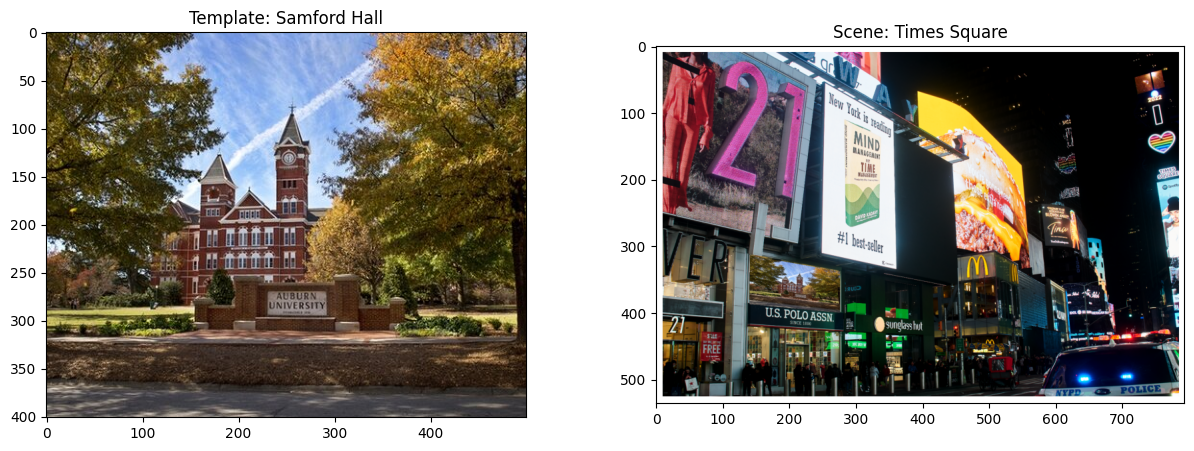

In [127]:
template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
scene_gray = cv2.cvtColor(scene, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(template, cv2.COLOR_BGR2RGB))
plt.title('Template: Samford Hall')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(scene, cv2.COLOR_BGR2RGB))
plt.title('Scene: Times Square')
plt.show()

## Detect Keypoints

Each circle is the location of some local extrema. The line from the circle shows which direction the gradient is coming from. The size of the circle is how large the keypoint is. For example, some fine grained visual detail will have a small circle, but some coarse detail will have a big circle.

Keypoints in template: 2085
Keypoints in scene: 3135


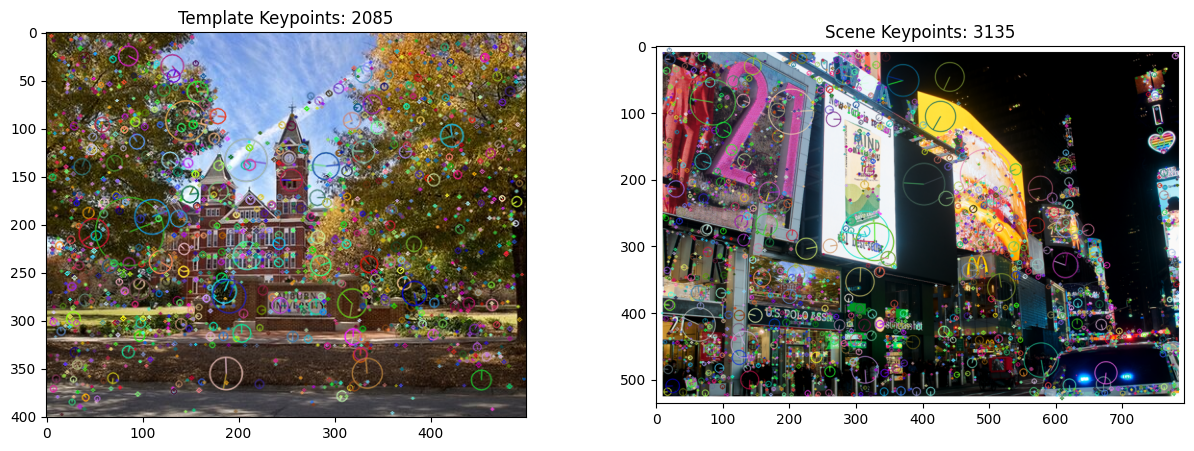

In [128]:
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(template_gray, None)
kp2, des2 = sift.detectAndCompute(scene_gray, None)

print(f"Keypoints in template: {len(kp1)}")
print(f"Keypoints in scene: {len(kp2)}")

# Optional: Visualize keypoints
img_kp1 = cv2.drawKeypoints(template, kp1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_kp2 = cv2.drawKeypoints(scene, kp2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_kp1, cv2.COLOR_BGR2RGB))
plt.title(f'Template Keypoints: {len(kp1)}')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_kp2, cv2.COLOR_BGR2RGB))
plt.title(f'Scene Keypoints: {len(kp2)}')
plt.show()

## Brute force matcher

`NORM_L2` (euclidian distance) is the distance metric we are using. A smaller distance indicates a closer match.

In this code we are comparing every descriptor to every other descriptor in the original image. Then, we are only keeping the `k` closest matches. 

In [129]:
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
matches = bf.knnMatch(des1, des2, k=2)

print(f"Total initial matches: {len(matches)}")

Total initial matches: 2085


## FLANN

Another way to compare the descriptors is to use more sophisticated data structures through methods like FLANN. This ensures that we don't have to compare _every_ descriptor against every other descriptor. This is much faster, but it can give potentially worse results. Therefore, I am just using the brute force method.

In [130]:
# FLANN_INDEX_KDTREE = 1
# index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
# search_params = dict(checks=50)

# flann = cv2.FlannBasedMatcher(index_params, search_params)
# matches = flann.knnMatch(des1, des2, k=2)

## Lowe's Ratio Test

We want to filter down to only confident matches. For each template feature,  we find the best match and second-best match in the scene image. We then compare these two candidates: if the best match is significantly better than the second-best match (ratio < 0.75), we keep it because the match is distinctive. If the best and second-best are too similar (ratio >= 0.75), we discard it because the match is ambiguous.

Good matches after ratio test: 23


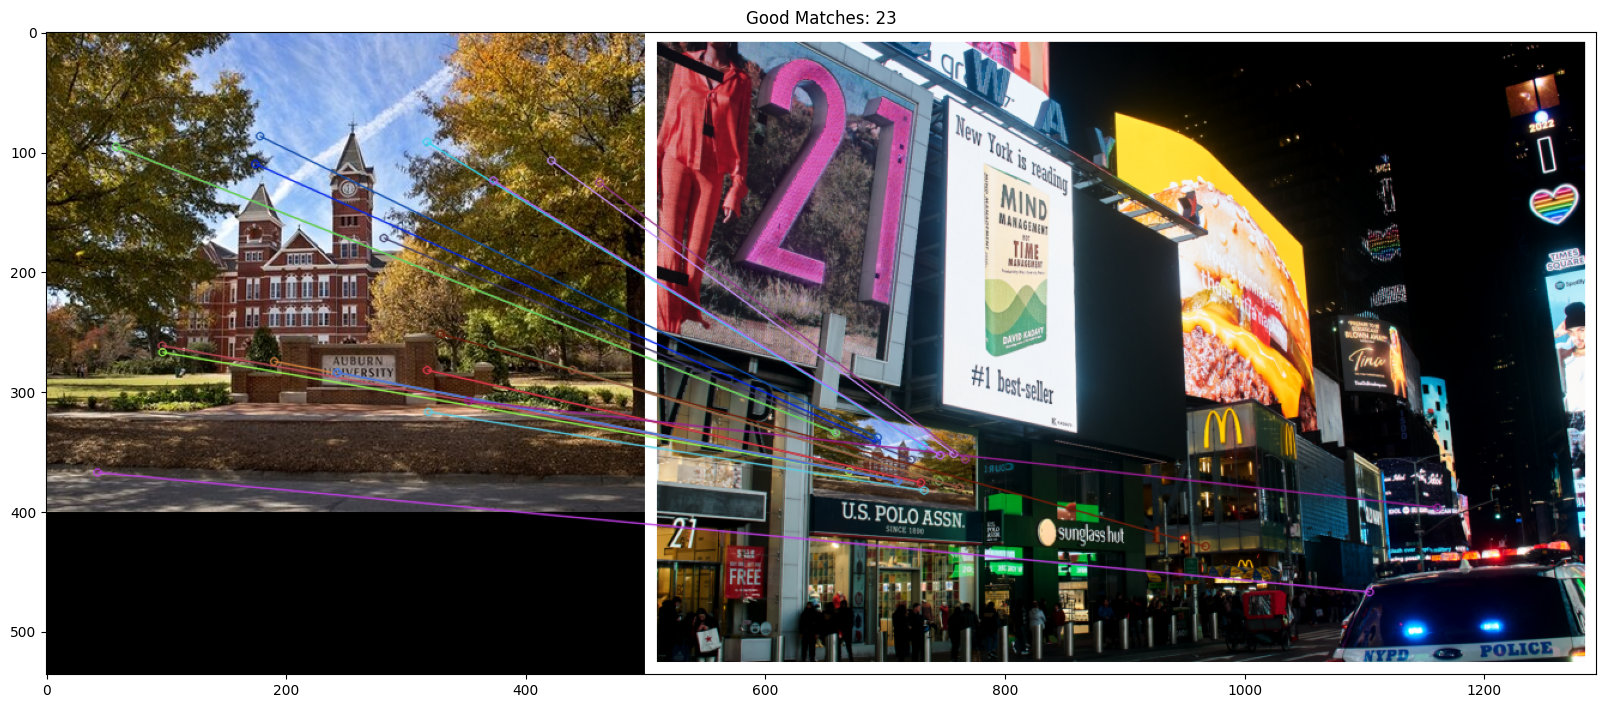

In [131]:
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

print(f"Good matches after ratio test: {len(good_matches)}")

img_matches = cv2.drawMatches(
    template, kp1, 
    scene, kp2, 
    good_matches, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.title(f'Good Matches: {len(good_matches)}')
plt.show()

## Homography

We want a 3×3 matrix that describes how to transform points from one image to another. RANSAC helps us find the best matrix for this while ignoring outliars.

It randomly picks 4 matches and then creates the homography matrix H from it. Then it tests how many matches agree with H and how many disagree.

In [132]:
src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# Compute homography using RANSAC
# H = 3x3 transformation matrix
# mask = inliers (1) vs outliers (0)
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

matches_mask = mask.ravel().tolist()
inliers = sum(matches_mask)

print(f"Homography computed with {inliers} inliers out of {len(good_matches)} matches")
print(f"Homography matrix:\n{H}")

Homography computed with 20 inliers out of 23 matches
Homography matrix:
[[ 3.49604351e-01 -6.07896645e-04  1.41584718e+02]
 [ 1.42335259e-01  1.83667722e-01  3.14592983e+02]
 [ 2.83008126e-04  1.23220310e-05  1.00000000e+00]]


## Perspective Shift

Now that we have the homography matrix, we need to visualize the results. We get the bounding box data of the original image of Samford Hall, and then multipl it with H to transform it to the location in the new image.

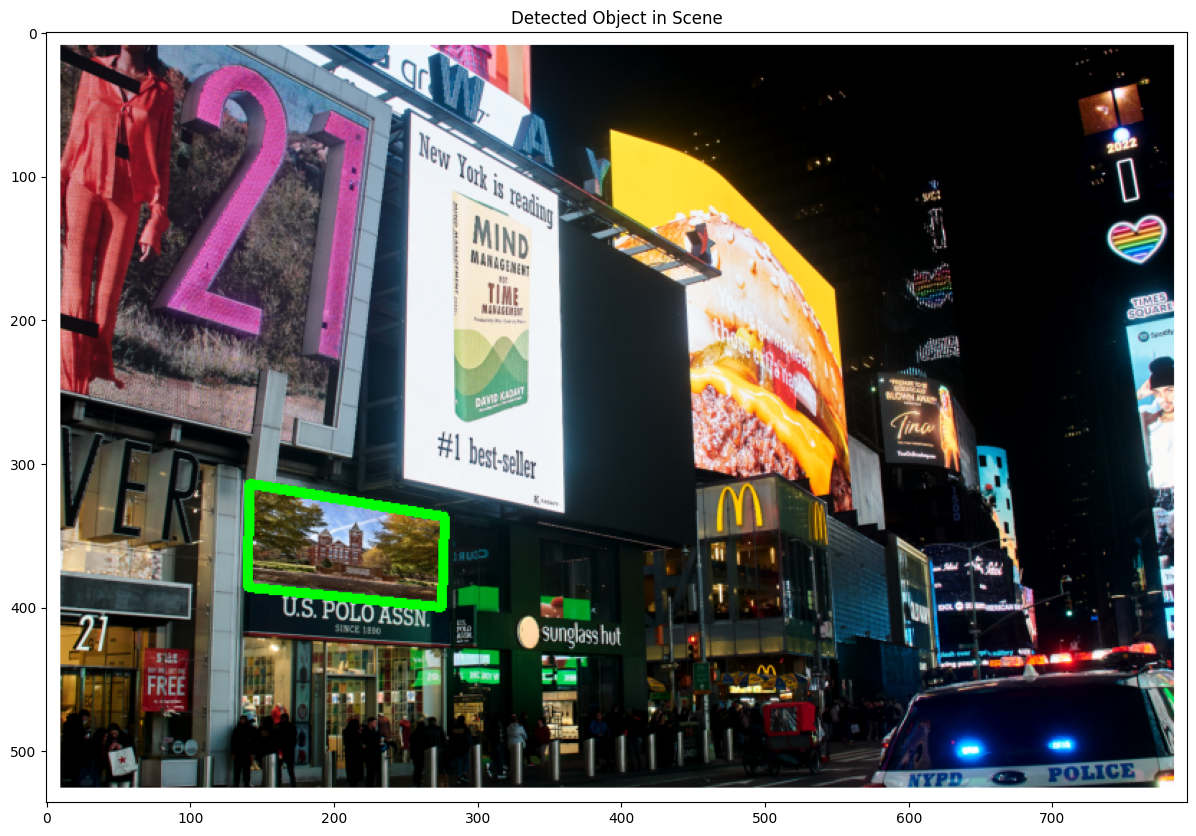

Result saved as 'result_detected.png'


In [133]:
h, w = template_gray.shape

pts = np.float32([
    [0, 0],           # Top-left
    [w, 0],           # Top-right
    [w, h],           # Bottom-right
    [0, h]            # Bottom-left
]).reshape(-1, 1, 2)

# Transform corners using homography
dst = cv2.perspectiveTransform(pts, H)

# Draw polygon on scene
scene_with_box = scene.copy()
scene_with_box = cv2.polylines(
    scene_with_box, 
    [np.int32(dst)], 
    isClosed=True, 
    color=(0, 255, 0),
    thickness=5
)

# Display result
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(scene_with_box, cv2.COLOR_BGR2RGB))
plt.title('Detected Object in Scene')
plt.show()

# Save result
cv2.imwrite('result_detected.png', scene_with_box)
print("Result saved as 'result_detected.png'")

# Task 2

Here, I'm detecting a HUGE number of keypoints. While it may seem excessive, this seems to be key for getting good performance. Using the default SIFT parameters did not work very well for me.

Keypoints in template: 830183
Keypoints in scene: 8313


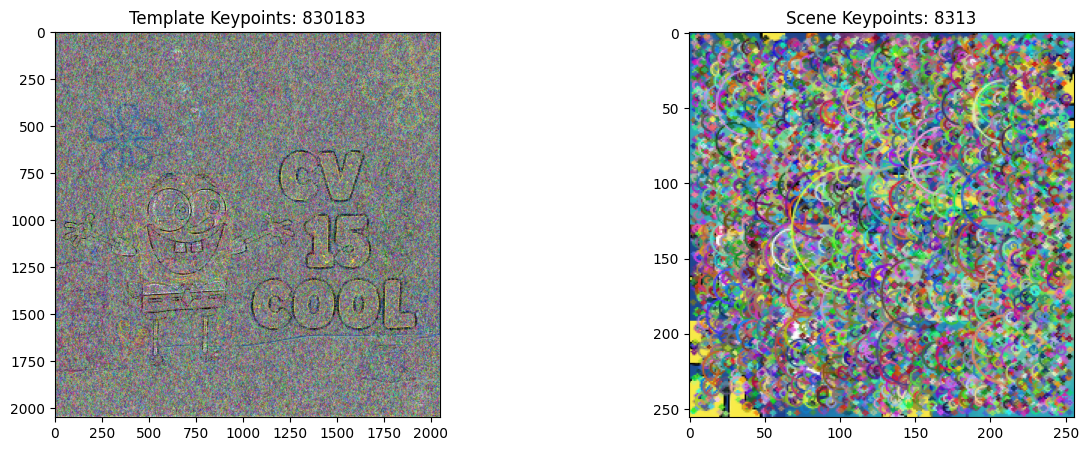

In [134]:
original = cv2.imread('puzzle_reference.png')
scrambled = cv2.imread('puzzle_scrambled.png')

original_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
scrambled_gray = cv2.cvtColor(scrambled, cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create(
    nfeatures=0,              
    nOctaveLayers=50,         
    contrastThreshold=0.0001, 
    edgeThreshold=25,         
    sigma=1.7                 
)
kp1, des1 = sift.detectAndCompute(original_gray, None)
kp2, des2 = sift.detectAndCompute(scrambled_gray, None)

print(f"Keypoints in template: {len(kp1)}")
print(f"Keypoints in scene: {len(kp2)}")

img_kp1 = cv2.drawKeypoints(original, kp1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_kp2 = cv2.drawKeypoints(scrambled, kp2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)

plt.imshow(cv2.cvtColor(img_kp1, cv2.COLOR_BGR2RGB))
plt.title(f'Template Keypoints: {len(kp1)}')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_kp2, cv2.COLOR_BGR2RGB))
plt.title(f'Scene Keypoints: {len(kp2)}')
plt.show()


In [ ]:
original = cv2.imread('puzzle_reference.png')
scrambled = cv2.imread('puzzle_scrambled.png')

print(f"Original shape: {original.shape}")
print(f"Scrambled shape: {scrambled.shape}")

original_resized = cv2.resize(original, (256, 256), interpolation=cv2.INTER_AREA)
original_gray = cv2.cvtColor(original_resized, cv2.COLOR_BGR2GRAY)
scrambled_gray = cv2.cvtColor(scrambled, cv2.COLOR_BGR2GRAY)

tile_size = 64
grid_size = 4

Original shape: (2048, 2048, 3)
Scrambled shape: (256, 256, 3)


In [136]:
ref_tiles = []

for row in range(grid_size):
    for col in range(grid_size):
        y = row * tile_size
        x = col * tile_size
        
        ref_tile_gray = original_gray[y:y+tile_size, x:x+tile_size]
        ref_tile_color = original_resized[y:y+tile_size, x:x+tile_size]
        
        kp, des = sift.detectAndCompute(ref_tile_gray, None)
        
        ref_tiles.append({
            'gray': ref_tile_gray,
            'color': ref_tile_color,
            'keypoints': kp,
            'descriptors': des,
            'position': (row, col)
        })
        print(f"Reference tile ({row},{col}): {len(kp) if kp else 0} keypoints")

scrambled_tiles = []

for row in range(grid_size):
    for col in range(grid_size):
        y = row * tile_size
        x = col * tile_size
        
        scr_tile_gray = scrambled_gray[y:y+tile_size, x:x+tile_size]
        scr_tile_color = scrambled[y:y+tile_size, x:x+tile_size]
        
        kp, des = sift.detectAndCompute(scr_tile_gray, None)
        
        scrambled_tiles.append({
            'gray': scr_tile_gray,
            'color': scr_tile_color,
            'keypoints': kp,
            'descriptors': des,
            'scrambled_position': (row, col)
        })
        print(f"Scrambled tile ({row},{col}): {len(kp) if kp else 0} keypoints")


Reference tile (0,0): 484 keypoints
Reference tile (0,1): 463 keypoints
Reference tile (0,2): 450 keypoints
Reference tile (0,3): 364 keypoints
Reference tile (1,0): 347 keypoints
Reference tile (1,1): 356 keypoints
Reference tile (1,2): 336 keypoints
Reference tile (1,3): 376 keypoints
Reference tile (2,0): 393 keypoints
Reference tile (2,1): 304 keypoints
Reference tile (2,2): 289 keypoints
Reference tile (2,3): 312 keypoints
Reference tile (3,0): 409 keypoints
Reference tile (3,1): 379 keypoints
Reference tile (3,2): 334 keypoints
Reference tile (3,3): 320 keypoints
Scrambled tile (0,0): 493 keypoints
Scrambled tile (0,1): 467 keypoints
Scrambled tile (0,2): 506 keypoints
Scrambled tile (0,3): 453 keypoints
Scrambled tile (1,0): 587 keypoints
Scrambled tile (1,1): 473 keypoints
Scrambled tile (1,2): 387 keypoints
Scrambled tile (1,3): 542 keypoints
Scrambled tile (2,0): 369 keypoints
Scrambled tile (2,1): 431 keypoints
Scrambled tile (2,2): 424 keypoints
Scrambled tile (2,3): 435 ke

Scrambled tile 0 matched to position (1, 3) with 351 inliers
Scrambled tile 1 matched to position (3, 0) with 53 inliers
Scrambled tile 2 matched to position (2, 0) with 51 inliers
Scrambled tile 3 matched to position (1, 2) with 255 inliers
Scrambled tile 4 matched to position (0, 0) with 242 inliers
Scrambled tile 5 matched to position (3, 1) with 68 inliers
Scrambled tile 6 matched to position (2, 2) with 254 inliers
Scrambled tile 7 matched to position (2, 3) with 61 inliers
Scrambled tile 8 matched to position (2, 1) with 261 inliers
Scrambled tile 9 matched to position (3, 3) with 298 inliers
Scrambled tile 10 matched to position (3, 2) with 246 inliers
Scrambled tile 11 matched to position (0, 3) with 247 inliers
Scrambled tile 12 matched to position (2, 3) with 267 inliers
Scrambled tile 13 matched to position (1, 1) with 313 inliers
Scrambled tile 14 matched to position (1, 0) with 289 inliers
Scrambled tile 15 matched to position (0, 2) with 227 inliers

--- Greedy Assignment

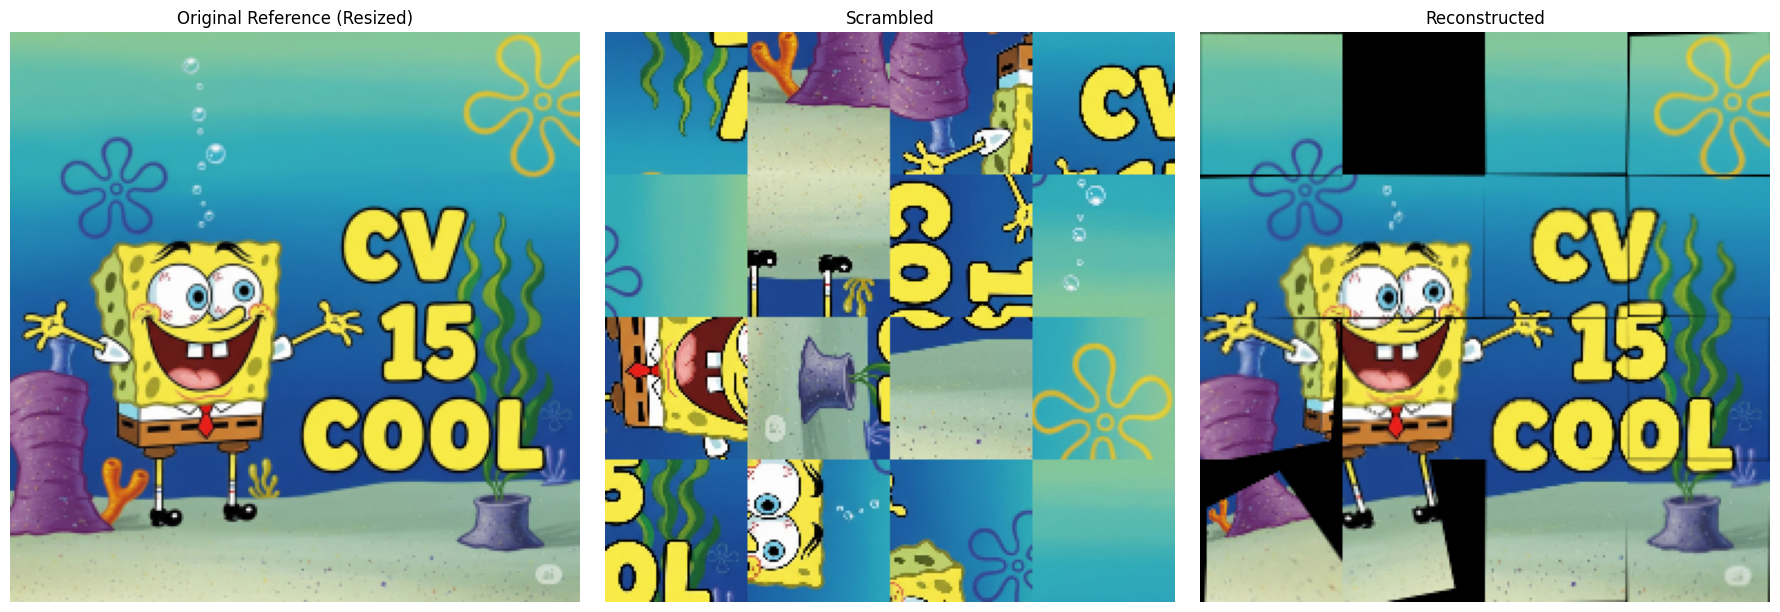

In [137]:
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
tile_matches = []

for scr_idx, scr_tile in enumerate(scrambled_tiles):
    if scr_tile['descriptors'] is None or len(scr_tile['keypoints']) < 3: 
        print(f"Scrambled tile {scr_idx}: Not enough features, skipping")
        continue
    
    best_match_count = 0
    best_ref_idx = -1
    best_H = None
    
    for ref_idx, ref_tile in enumerate(ref_tiles):
        if ref_tile['descriptors'] is None or len(ref_tile['keypoints']) < 4:
            continue
        
        matches = bf.knnMatch(scr_tile['descriptors'], ref_tile['descriptors'], k=2)
        
        good_matches = []
        for m_n in matches:
            if len(m_n) == 2:
                m, n = m_n
                if m.distance < 0.94 * n.distance:
                    good_matches.append(m)
        
        if len(good_matches) >= 4:
            src_pts = np.float32([scr_tile['keypoints'][m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            dst_pts = np.float32([ref_tile['keypoints'][m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            
            H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            if H is not None:
                inliers = np.sum(mask)
            else:
                continue
            
            if H is not None and inliers > best_match_count:
                best_match_count = inliers
                best_ref_idx = ref_idx
                best_H = H
    
    if best_ref_idx >= 0 and best_H is not None:
        tile_matches.append({
            'scr_idx': scr_idx,
            'ref_idx': best_ref_idx,
            'ref_position': ref_tiles[best_ref_idx]['position'],
            'inliers': best_match_count,
            'homography': best_H,
            'tile_color': scr_tile['color']
        })
        print(f"Scrambled tile {scr_idx} matched to position {ref_tiles[best_ref_idx]['position']} with {best_match_count} inliers")
    else:
        print(f"Scrambled tile {scr_idx}: No good match found")

# Sort by inliers
tile_matches.sort(key=lambda x: x['inliers'], reverse=True)

# Greedy assignment
used_positions = set()
used_scrambled = set()
reconstructed = np.zeros_like(scrambled)

print("\n--- Greedy Assignment ---")
for match in tile_matches:
    ref_position = match['ref_position']
    scr_idx = match['scr_idx']
    
    if ref_position not in used_positions and scr_idx not in used_scrambled:
        used_positions.add(ref_position)
        used_scrambled.add(scr_idx)
        
        warped_tile = cv2.warpPerspective(match['tile_color'], 
                                          match['homography'], 
                                          (tile_size, tile_size))
        
        y = ref_position[0] * tile_size
        x = ref_position[1] * tile_size
        reconstructed[y:y+tile_size, x:x+tile_size] = warped_tile
        
        print(f"✓ Assigned scrambled tile {scr_idx} -> position {ref_position} (inliers: {match['inliers']})")
    else:
        print(f"✗ Skipped scrambled tile {scr_idx} -> position {ref_position} (already assigned)")

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(original_resized, cv2.COLOR_BGR2RGB))
plt.title('Original Reference (Resized)')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(scrambled, cv2.COLOR_BGR2RGB))
plt.title('Scrambled')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(reconstructed, cv2.COLOR_BGR2RGB))
plt.title('Reconstructed')
plt.axis('off')

plt.tight_layout()
plt.show()